In [50]:
# from thundersvm import SVC  # Import ThunderSVM SVC

In [51]:
# --------------------------------------------------
# Import Libraries and Set Up Environment
# --------------------------------------------------
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import parallel_backend

# Enable inline plotting
%matplotlib inline

# matplotlib.use('Agg')  # Use 'Agg' backend

# Set joblib temporary directory
os.environ['JOBLIB_TEMP_FOLDER'] = '/home/nrelab-titan/Desktop/shovon/temp_joblib' # Titan PC
# os.environ['JOBLIB_TEMP_FOLDER'] = '/home/shovon/Desktop/temp_joblib' # Asus Laptop

In [52]:
# --------------------------------------------------
# Load and Prepare Data
# --------------------------------------------------

# ----------------------------------------------------------------------------------------------------------------------------
# Load Noisy CSV files on ***| Asus Laptop |***

# 4 mm
# plain_terrain_file = '/home/shovon/Desktop/catkin_ws/src/stat_analysis/noise_csv_files/plain_terrain_features_4_mm.csv'
# grass_terrain_file = '/home/shovon/Desktop/catkin_ws/src/stat_analysis/noise_csv_files/grass_terrain_features_4_mm.csv'

# # 6 mm
# plain_terrain_file = '/home/shovon/Desktop/catkin_ws/src/stat_analysis/noise_csv_files/plain_terrain_features_6_mm.csv'
# grass_terrain_file = '/home/shovon/Desktop/catkin_ws/src/stat_analysis/noise_csv_files/grass_terrain_features_6_mm.csv'

# # 8 mm
# plain_terrain_file = '/home/shovon/Desktop/catkin_ws/src/stat_analysis/noise_csv_files/plain_terrain_features_8_mm.csv'
# grass_terrain_file = '/home/shovon/Desktop/catkin_ws/src/stat_analysis/noise_csv_files/grass_terrain_features_8_mm.csv'

# # 10 mm
# plain_terrain_file = '/home/shovon/Desktop/catkin_ws/src/stat_analysis/noise_csv_files/plain_terrain_features_10_mm.csv'
# grass_terrain_file = '/home/shovon/Desktop/catkin_ws/src/stat_analysis/noise_csv_files/grass_terrain_features_10_mm.csv'
# ----------------------------------------------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------------------------------------------
# Load Noisy CSV files on ***| TITAN PC |***

# 4 mm
# plain_terrain_file = '/home/nrelab-titan/Desktop/shovon/catkin_ws/src/stat_analysis/noise_csv_files/plain_terrain_features_4_mm.csv'
# grass_terrain_file = '/home/nrelab-titan/Desktop/shovon/catkin_ws/src/stat_analysis/noise_csv_files/grass_terrain_features_4_mm.csv'

# # 6 mm
# plain_terrain_file = '/home/nrelab-titan/Desktop/shovon/catkin_ws/src/stat_analysis/noise_csv_files/plain_terrain_features_6_mm.csv'
# grass_terrain_file = '/home/nrelab-titan/Desktop/shovon/catkin_ws/src/stat_analysis/noise_csv_files/grass_terrain_features_6_mm.csv'

# # 8 mm
# plain_terrain_file = '/home/nrelab-titan/Desktop/shovon/catkin_ws/src/stat_analysis/noise_csv_files/plain_terrain_features_8_mm.csv'
# grass_terrain_file = '/home/nrelab-titan/Desktop/shovon/catkin_ws/src/stat_analysis/noise_csv_files/grass_terrain_features_8_mm.csv'

# # 10 mm
plain_terrain_file = '/home/nrelab-titan/Desktop/shovon/catkin_ws/src/stat_analysis/noise_csv_files/plain_terrain_features_10_mm.csv'
grass_terrain_file = '/home/nrelab-titan/Desktop/shovon/catkin_ws/src/stat_analysis/noise_csv_files/grass_terrain_features_10_mm.csv'
# ----------------------------------------------------------------------------------------------------------------------------


# Load CSV files
plain_terrain_df = pd.read_csv(plain_terrain_file)
grass_terrain_df = pd.read_csv(grass_terrain_file)

plain_terrain_df['label'] = 'plain'
grass_terrain_df['label'] = 'grass'

# Concatenate the DataFrames
combined_df = pd.concat([plain_terrain_df, grass_terrain_df], ignore_index=True)

# Verify the combined DataFrame
print(combined_df.head())


         X         Y         Z   NormalX   NormalY   NormalZ  Intensity  label
0  2.83700 -0.531814 -0.665593  0.058542 -0.070014  0.995827    37.0000  plain
1  2.92607 -0.568941 -0.662900  0.058541 -0.070014  0.995827    37.0833  plain
2  2.85845 -0.466338 -0.652305  0.058542 -0.070014  0.995827    37.0000  plain
3  2.90376 -0.517318 -0.655100  0.058541 -0.070014  0.995827    36.0000  plain
4  2.43387 -0.533629 -0.617978  0.042156 -0.056462  0.997514    34.8000  plain


In [53]:
# plain_terrain_file = '/home/nrelab-titan/Desktop/shovon/catkin_ws/src/stat_analysis/noise_csv_files/plain_terrain_features_10_mm.csv'
# grass_terrain_file = '/home/nrelab-titan/Desktop/shovon/catkin_ws/src/stat_analysis/noise_csv_files/grass_terrain_features_10_mm.csv'
# ----------------------------------------------------------------------------------------------------------------------------


# Load CSV files
plain_terrain_df = pd.read_csv(plain_terrain_file)
grass_terrain_df = pd.read_csv(grass_terrain_file)

plain_terrain_df['label'] = 'plain'
grass_terrain_df['label'] = 'grass'

# Concatenate the DataFrames
combined_df = pd.concat([plain_terrain_df, grass_terrain_df], ignore_index=True)

# Verify the combined DataFrame
print(combined_df.head())


         X         Y         Z   NormalX   NormalY   NormalZ  Intensity  label
0  2.83700 -0.531814 -0.665593  0.058542 -0.070014  0.995827    37.0000  plain
1  2.92607 -0.568941 -0.662900  0.058541 -0.070014  0.995827    37.0833  plain
2  2.85845 -0.466338 -0.652305  0.058542 -0.070014  0.995827    37.0000  plain
3  2.90376 -0.517318 -0.655100  0.058541 -0.070014  0.995827    36.0000  plain
4  2.43387 -0.533629 -0.617978  0.042156 -0.056462  0.997514    34.8000  plain


In [54]:
# --------------------------------------------------
# Feature Extraction and Scaling
# --------------------------------------------------
# Features and labels
features = ['NormalX', 'NormalY']
X = combined_df[features]
y = combined_df['label'].map({'plain': 0, 'grass': 1})

# Set the percentage of the dataset to use for training
train_percentage = 0.9999  # 0.1 = 10%

# Split the data
X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size=train_percentage, stratify=y, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_rest_scaled = scaler.transform(X_rest)

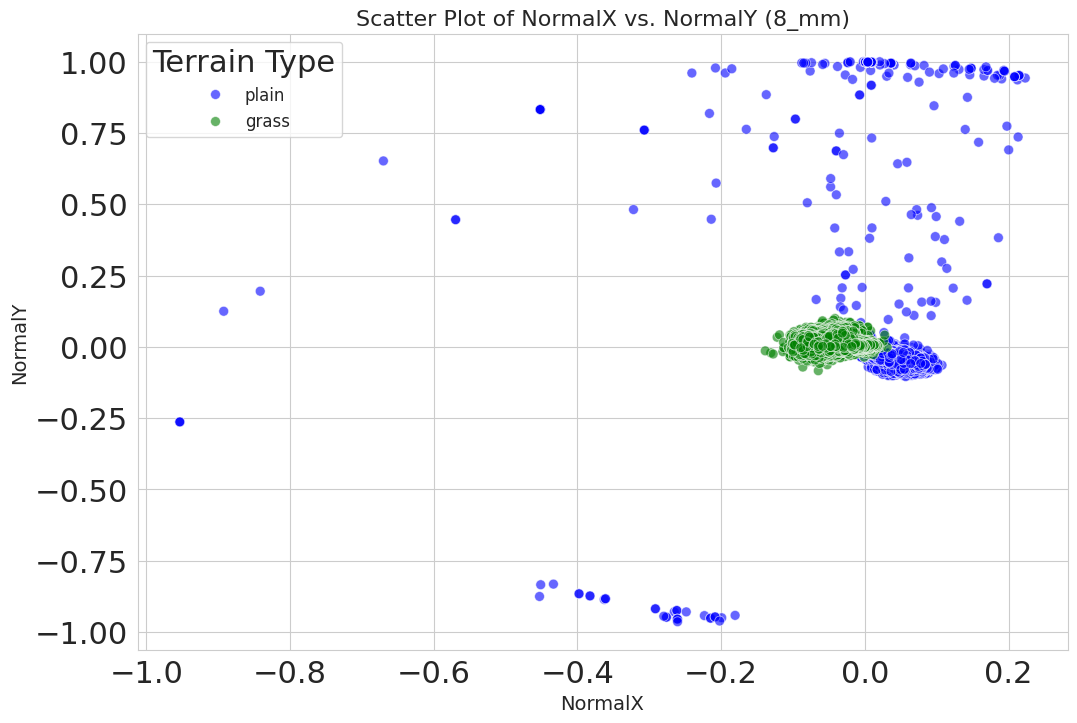

Plot saved as: /home/nrelab-titan/Desktop/shovon/catkin_ws/src/stat_analysis/model_results/terrain_classification/scatter_plot_8_mm.png


In [55]:
# --------------------------------------------------
# Feature Visualization before Model Training
# --------------------------------------------------
# Extract the file detail for the plot filename
csv_filename = os.path.basename(plain_terrain_file)  # Use one of the files to get the common part
number_mm = csv_filename.split('_')[-2] + '_' + csv_filename.split('_')[-1].split('.')[0]

# Specify the directory to save the plot
save_directory = '/home/nrelab-titan/Desktop/shovon/catkin_ws/src/stat_analysis/model_results/terrain_classification'

# Ensure the directory exists, and create it if it doesn't
os.makedirs(save_directory, exist_ok=True)

# Construct the plot file name with the full path
plot_filename = os.path.join(save_directory, f'scatter_plot_{number_mm}.png')

# Set the style for the plot
sns.set_style('whitegrid')

# Create a scatter plot of NormalX vs. NormalY
plt.figure(figsize=(12, 8))
sns.scatterplot(x='NormalX', y='NormalY', hue='label', data=combined_df, palette={'plain': 'blue', 'grass': 'green'}, alpha=0.6, s=50)

# Add plot details
plt.title(f'Scatter Plot of NormalX vs. NormalY ({number_mm})', fontsize=16)
plt.xlabel('NormalX', fontsize=14)
plt.ylabel('NormalY', fontsize=14)
plt.legend(title='Terrain Type', fontsize=12)
plt.grid(True)

# Save the plot in PNG
plt.savefig(plot_filename, bbox_inches='tight')

# Save the plot in SVG
plot_filename_svg = os.path.join(save_directory, f'scatter_plot_{number_mm}.svg')
plt.savefig(plot_filename_svg, format='svg', bbox_inches='tight')

# Show the plot
plt.show()

print(f'Plot saved as: {plot_filename}')

In [56]:
# --------------------------------------------------
# Model Training and Cross-Validation
# --------------------------------------------------
# Initialize the SVM model with specified parameters
svm_model = SVC(kernel='rbf', C=100, gamma=0.1, verbose=True)

# Perform 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function for parallel cross-validation prediction
def parallel_cross_val_predict(estimator, X, y, cv, method='predict'):
    with parallel_backend('loky'):
        return cross_val_predict(estimator, X, y, cv=cv, method=method, n_jobs=-1)

# Using parallel processing for cross_val_predict
y_pred = parallel_cross_val_predict(svm_model, X_train_scaled, y_train, skf)
y_decision = parallel_cross_val_predict(svm_model, X_train_scaled, y_train, skf, method='decision_function')

# Calculate accuracy metrics
accuracy = accuracy_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
conf_matrix = confusion_matrix(y_train, y_pred)

# Display metrics
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Generate a detailed classification report
class_report = classification_report(y_train, y_pred, target_names=['plain', 'grass'])
print("Classification Report:")
print(class_report)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]...
*.

**
optimization finished, #iter = 2554

optimization finished, #iter = 1755
obj = -74745.635344, rho = -9.634682
nSV = 770, nBSV = 762
Total nSV = 770

obj = -72805.240811, rho = -7.958144
nSV = 748, nBSV = 742
Total nSV = 748
*
optimization finished, #iter = 1762
obj = -74601.730140, rho = -6.535259
nSV = 767, nBSV = 761
Total nSV = 767
.
*.*
optimization finished, #iter = 2004
obj = -78235.457836, rho = -7.662545
nSV = 804, nBSV = 796
Total nSV = 804
..
*
optimization finished, #iter = 2625
obj = -75883.539863, rho = -9.257945
nSV = 781, nBSV = 773
Total nSV = 781
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]..
*
optimization finished, #iter = 1755
obj = -72805.240811, rho = -7.958144
nSV = 748, nBSV = 742
Total nSV = 748
.
*...
*
optimization finished, #iter = 2554

*
optimization finished, #iter = 1762
obj = -74745.635344, rho = -9.634682
nSV = 770, nBSV = 762
Total nSV = 770

obj = -74601.730140, rho = -6.535259
nSV = 767, nBSV = 761
Tota

In [57]:
# --------------------------------------------------
# Calculate and Print Metrics
# --------------------------------------------------
# Calculate metrics
accuracy = accuracy_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
roc_auc = roc_auc_score(y_train, y_decision)

# Compute TPR, FPR
fpr, tpr, thresholds = roc_curve(y_train, y_decision)

# Confusion matrix
cm = confusion_matrix(y_train, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate additional metrics
tpr_value = tp / (tp + fn)  # True Positive Rate (Recall)
fpr_value = fp / (fp + tn)  # False Positive Rate

# Specify the directory to save the metrics
save_directory = '/home/nrelab-titan/Desktop/shovon/catkin_ws/src/stat_analysis/model_results/terrain_classification'
os.makedirs(save_directory, exist_ok=True)

# Construct the metrics file name
metrics_filename = os.path.join(save_directory, f'classification_metrics_{number_mm}.txt')

# Open the file in write mode
with open(metrics_filename, 'w') as f:
    # Print metrics to the file
    f.write(f"Accuracy: {accuracy}\n")
    f.write(f"F1 Score: {f1}\n")
    f.write(f"AUC: {roc_auc}\n")
    f.write(f"TPR: {tpr_value}\n")
    f.write(f"FPR: {fpr_value}\n")
    f.write("\nConfusion Matrix:\n")
    f.write(f"{cm}\n")
    f.write("\nClassification Report:\n")
    f.write(classification_report(y_train, y_pred, target_names=['plain', 'grass']))
    
# Optionally, also print the results to the console
print(f"Metrics saved to {metrics_filename}")

# Print to console (if desired)
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"AUC: {roc_auc}")
print(f"TPR: {tpr_value}")
print(f"FPR: {fpr_value}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_train, y_pred, target_names=['plain', 'grass']))

Metrics saved to /home/nrelab-titan/Desktop/shovon/catkin_ws/src/stat_analysis/model_results/terrain_classification/classification_metrics_8_mm.txt
Accuracy: 0.9991922247112138
F1 Score: 0.9993202228279165
AUC: 0.9999795964235024
TPR: 0.9995003931688541
FPR: 0.0012587172526906671

Confusion Matrix:
[[157105    198]
 [   115 230066]]

Classification Report:
              precision    recall  f1-score   support

       plain       1.00      1.00      1.00    157303
       grass       1.00      1.00      1.00    230181

    accuracy                           1.00    387484
   macro avg       1.00      1.00      1.00    387484
weighted avg       1.00      1.00      1.00    387484



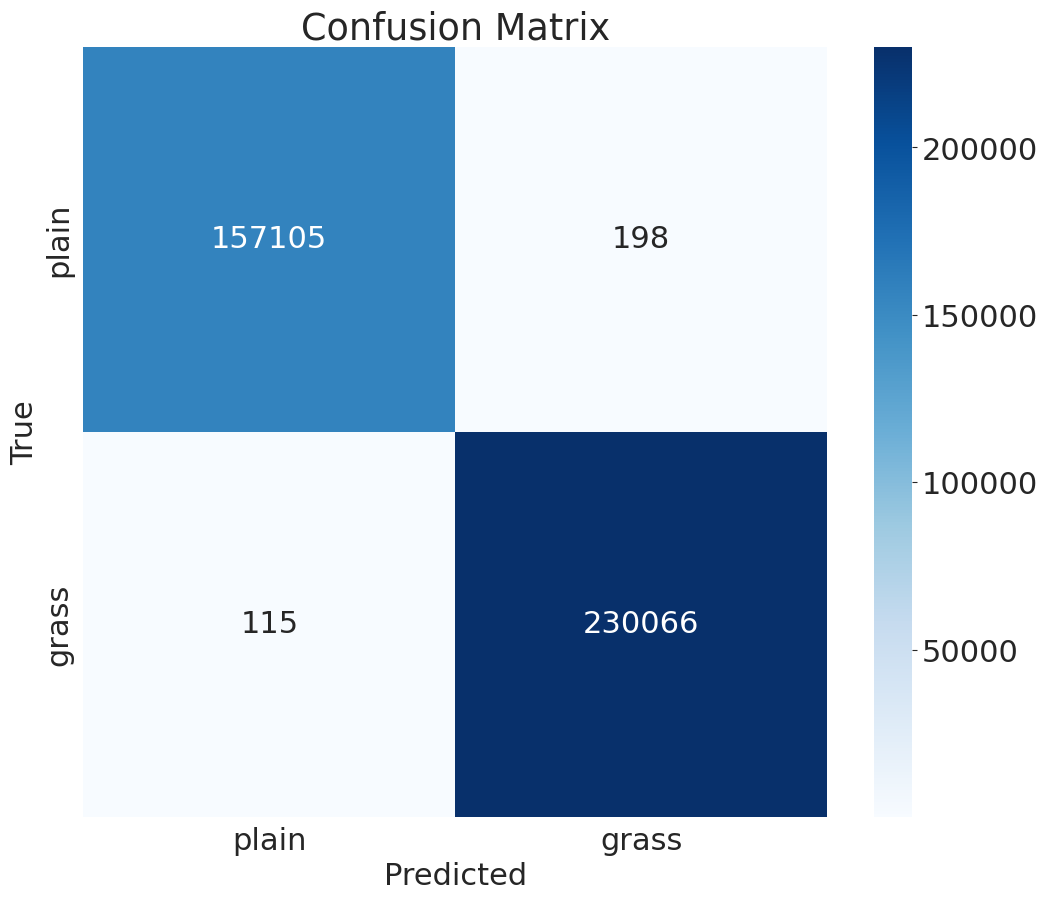

Confusion matrix plot saved to: /home/nrelab-titan/Desktop/shovon/catkin_ws/src/stat_analysis/model_results/terrain_classification/confusion_matrix_8_mm.png


In [58]:
# --------------------------------------------------
# Plot Confusion Matrix
# --------------------------------------------------

# Set the directory where you want to save the plots
save_directory = '/home/nrelab-titan/Desktop/shovon/catkin_ws/src/stat_analysis/model_results/terrain_classification'

# Ensure the directory exists
os.makedirs(save_directory, exist_ok=True)

# Increase text size for plots
plt.rcParams.update({'font.size': 22})

# Plot Confusion Matrix using Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['plain', 'grass'], yticklabels=['plain', 'grass'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Construct the file name and the save the figure
# In PNG
confusion_matrix_path = os.path.join(save_directory, f'confusion_matrix_{number_mm}.png')
plt.savefig(confusion_matrix_path)

# In SVG
confusion_matrix_path_svg = os.path.join(save_directory, f'confusion_matrix_{number_mm}.svg')
plt.savefig(confusion_matrix_path_svg, format='svg', bbox_inches='tight')


# Show the plot
plt.show()

print(f"Confusion matrix plot saved to: {confusion_matrix_path}")

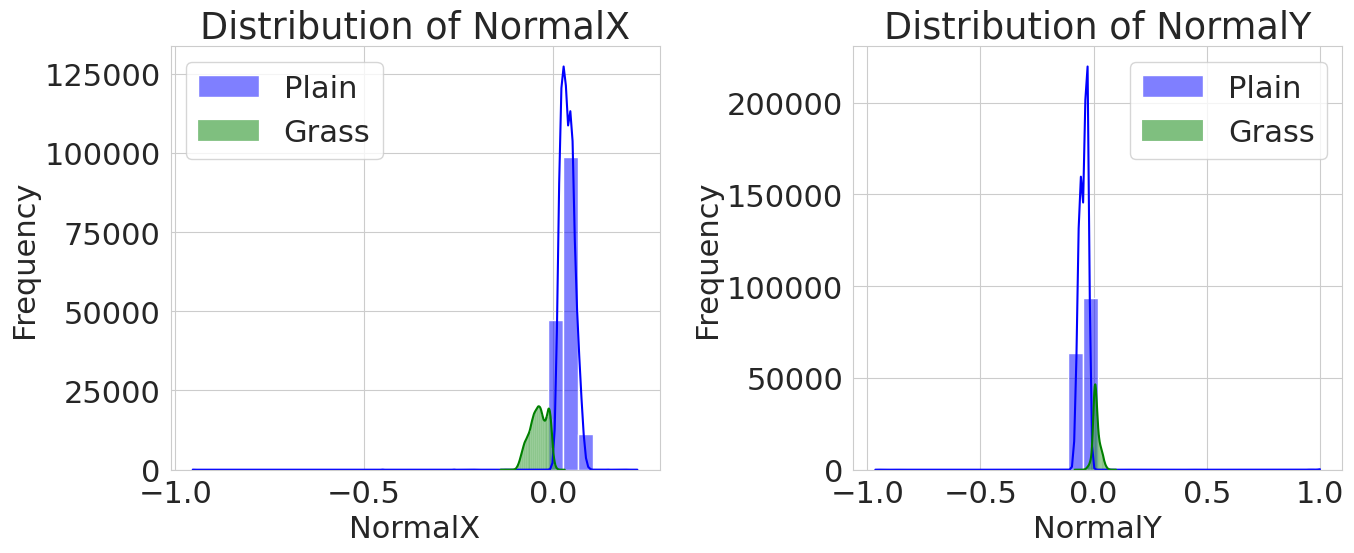

In [59]:
# Plot side by side histograms for NormalX
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(plain_terrain_df['NormalX'], kde=True, bins=30, color='blue', label='Plain')
sns.histplot(grass_terrain_df['NormalX'], kde=True, bins=30, color='green', label='Grass')
plt.title('Distribution of NormalX')
plt.xlabel('NormalX')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# Plot side by side histograms for NormalY
plt.subplot(1, 2, 2)
sns.histplot(plain_terrain_df['NormalY'], kde=True, bins=30, color='blue', label='Plain')
sns.histplot(grass_terrain_df['NormalY'], kde=True, bins=30, color='green', label='Grass')
plt.xlabel('NormalY')
plt.title('Distribution of NormalY')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
